## G2100287K
## Noel Sanghyuk Son

In [4]:
import pandas as pd

In [5]:
df = pd.read_csv("Credit Card Default.csv", index_col=0)
df

,income,age,loan,default
clientid,,,,
1,66155.92510,59.017015,8106.532131,0
2,34415.15397,48.117153,6564.745018,0
3,57317.17006,63.108049,8020.953296,0
4,42709.53420,45.751972,6103.642260,0
5,66952.68885,18.584336,8770.099235,1
...,...,...,...,...
1996,59221.04487,48.518179,1926.729397,0
1997,69516.12757,23.162104,3503.176156,0
1998,44311.44926,28.017167,5522.786693,1


### Check and Remove NA values

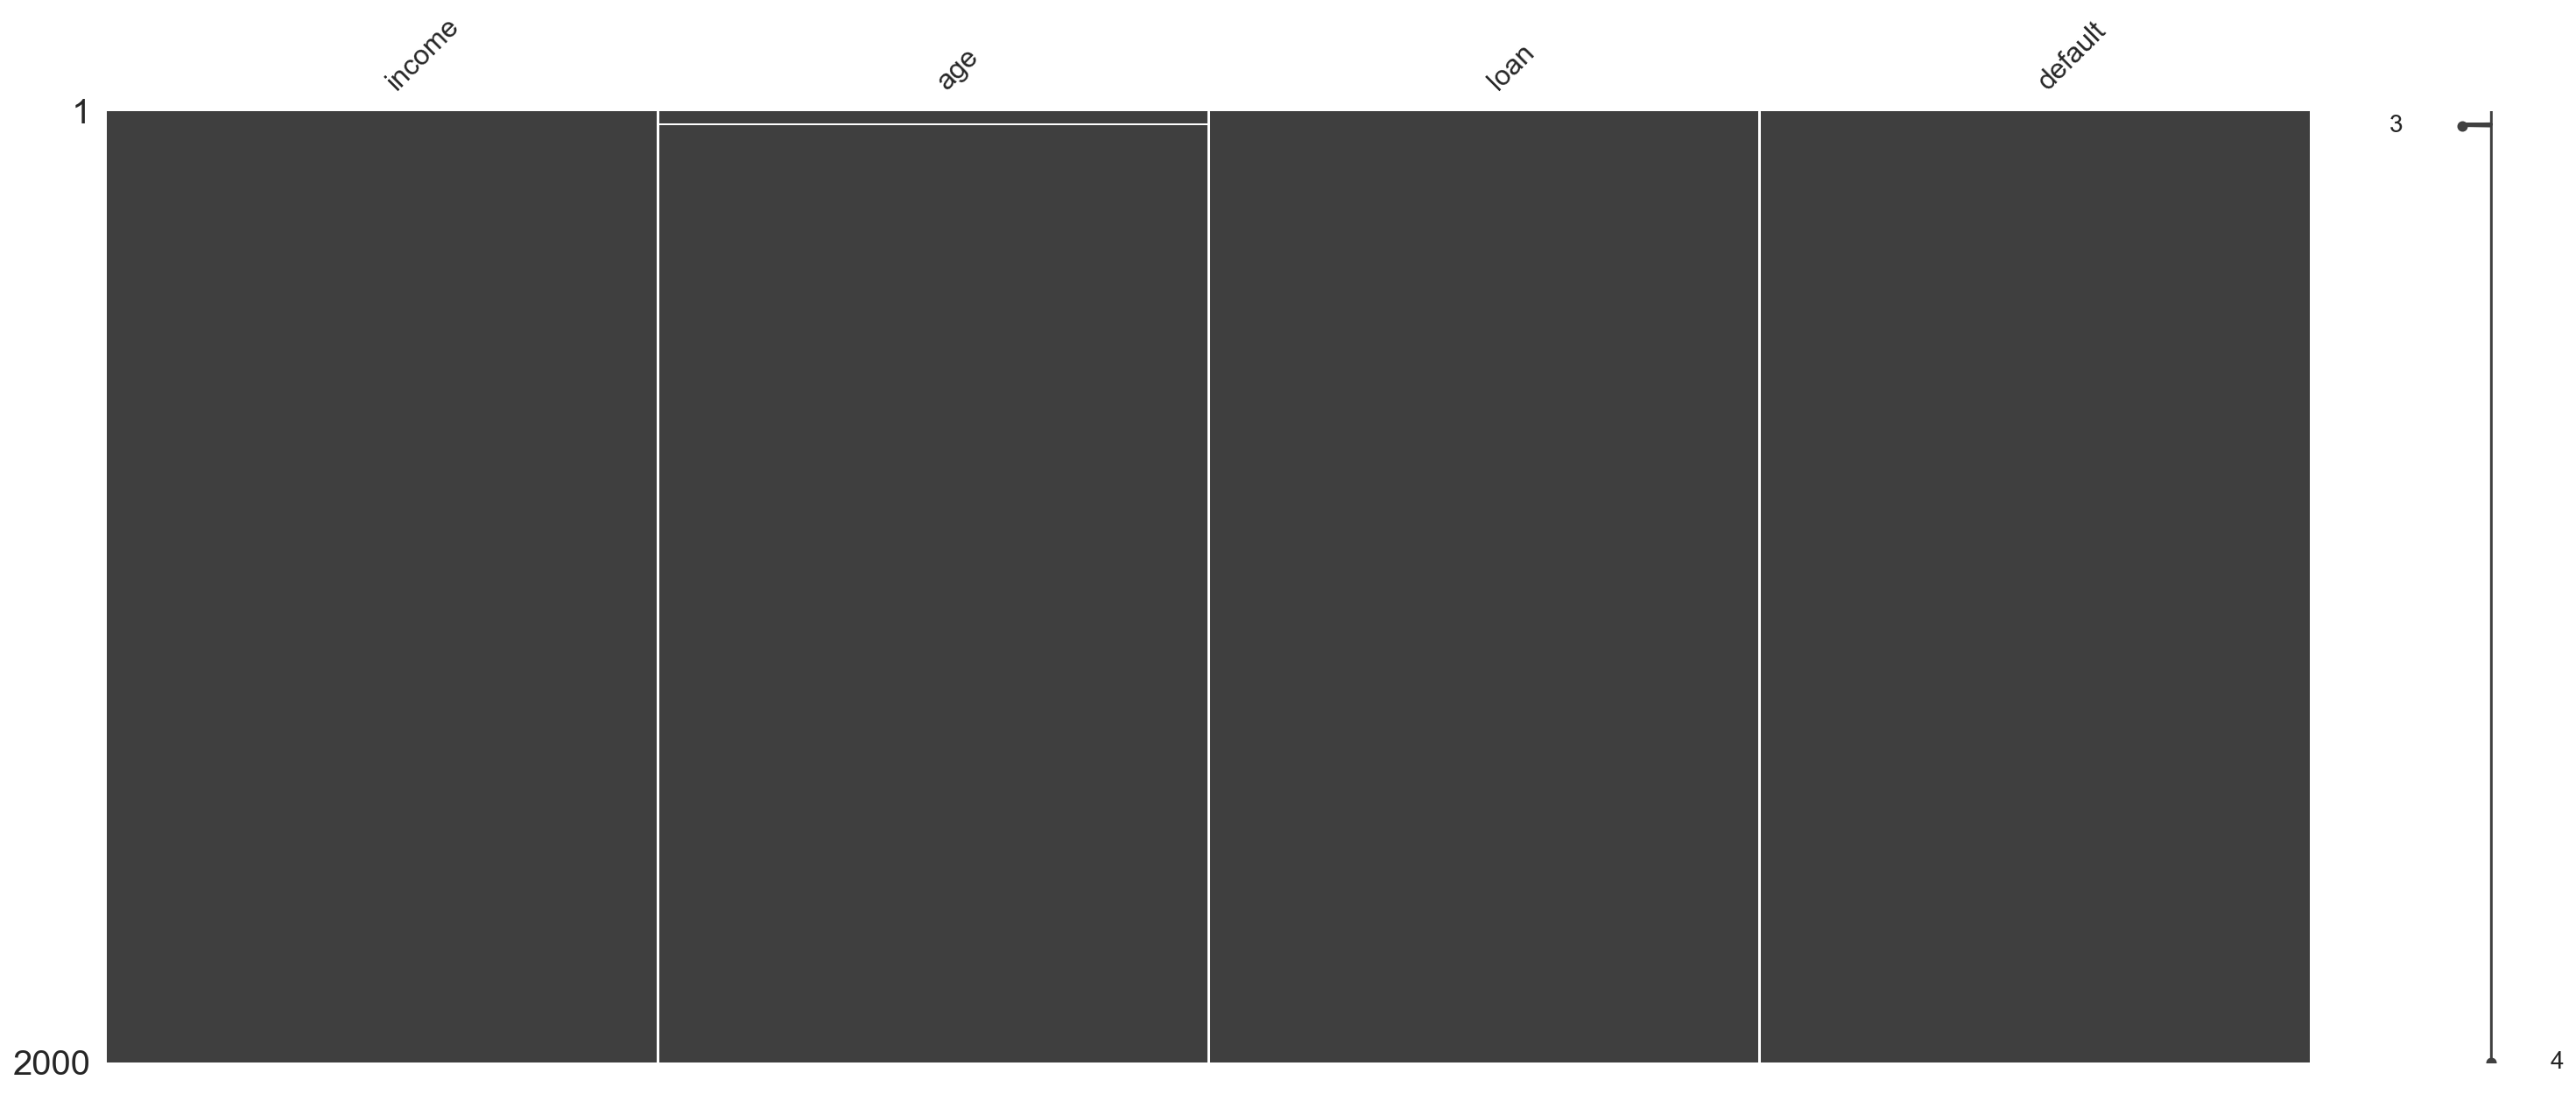

In [6]:
import missingno as msno

msno.matrix(df)
plt.show()

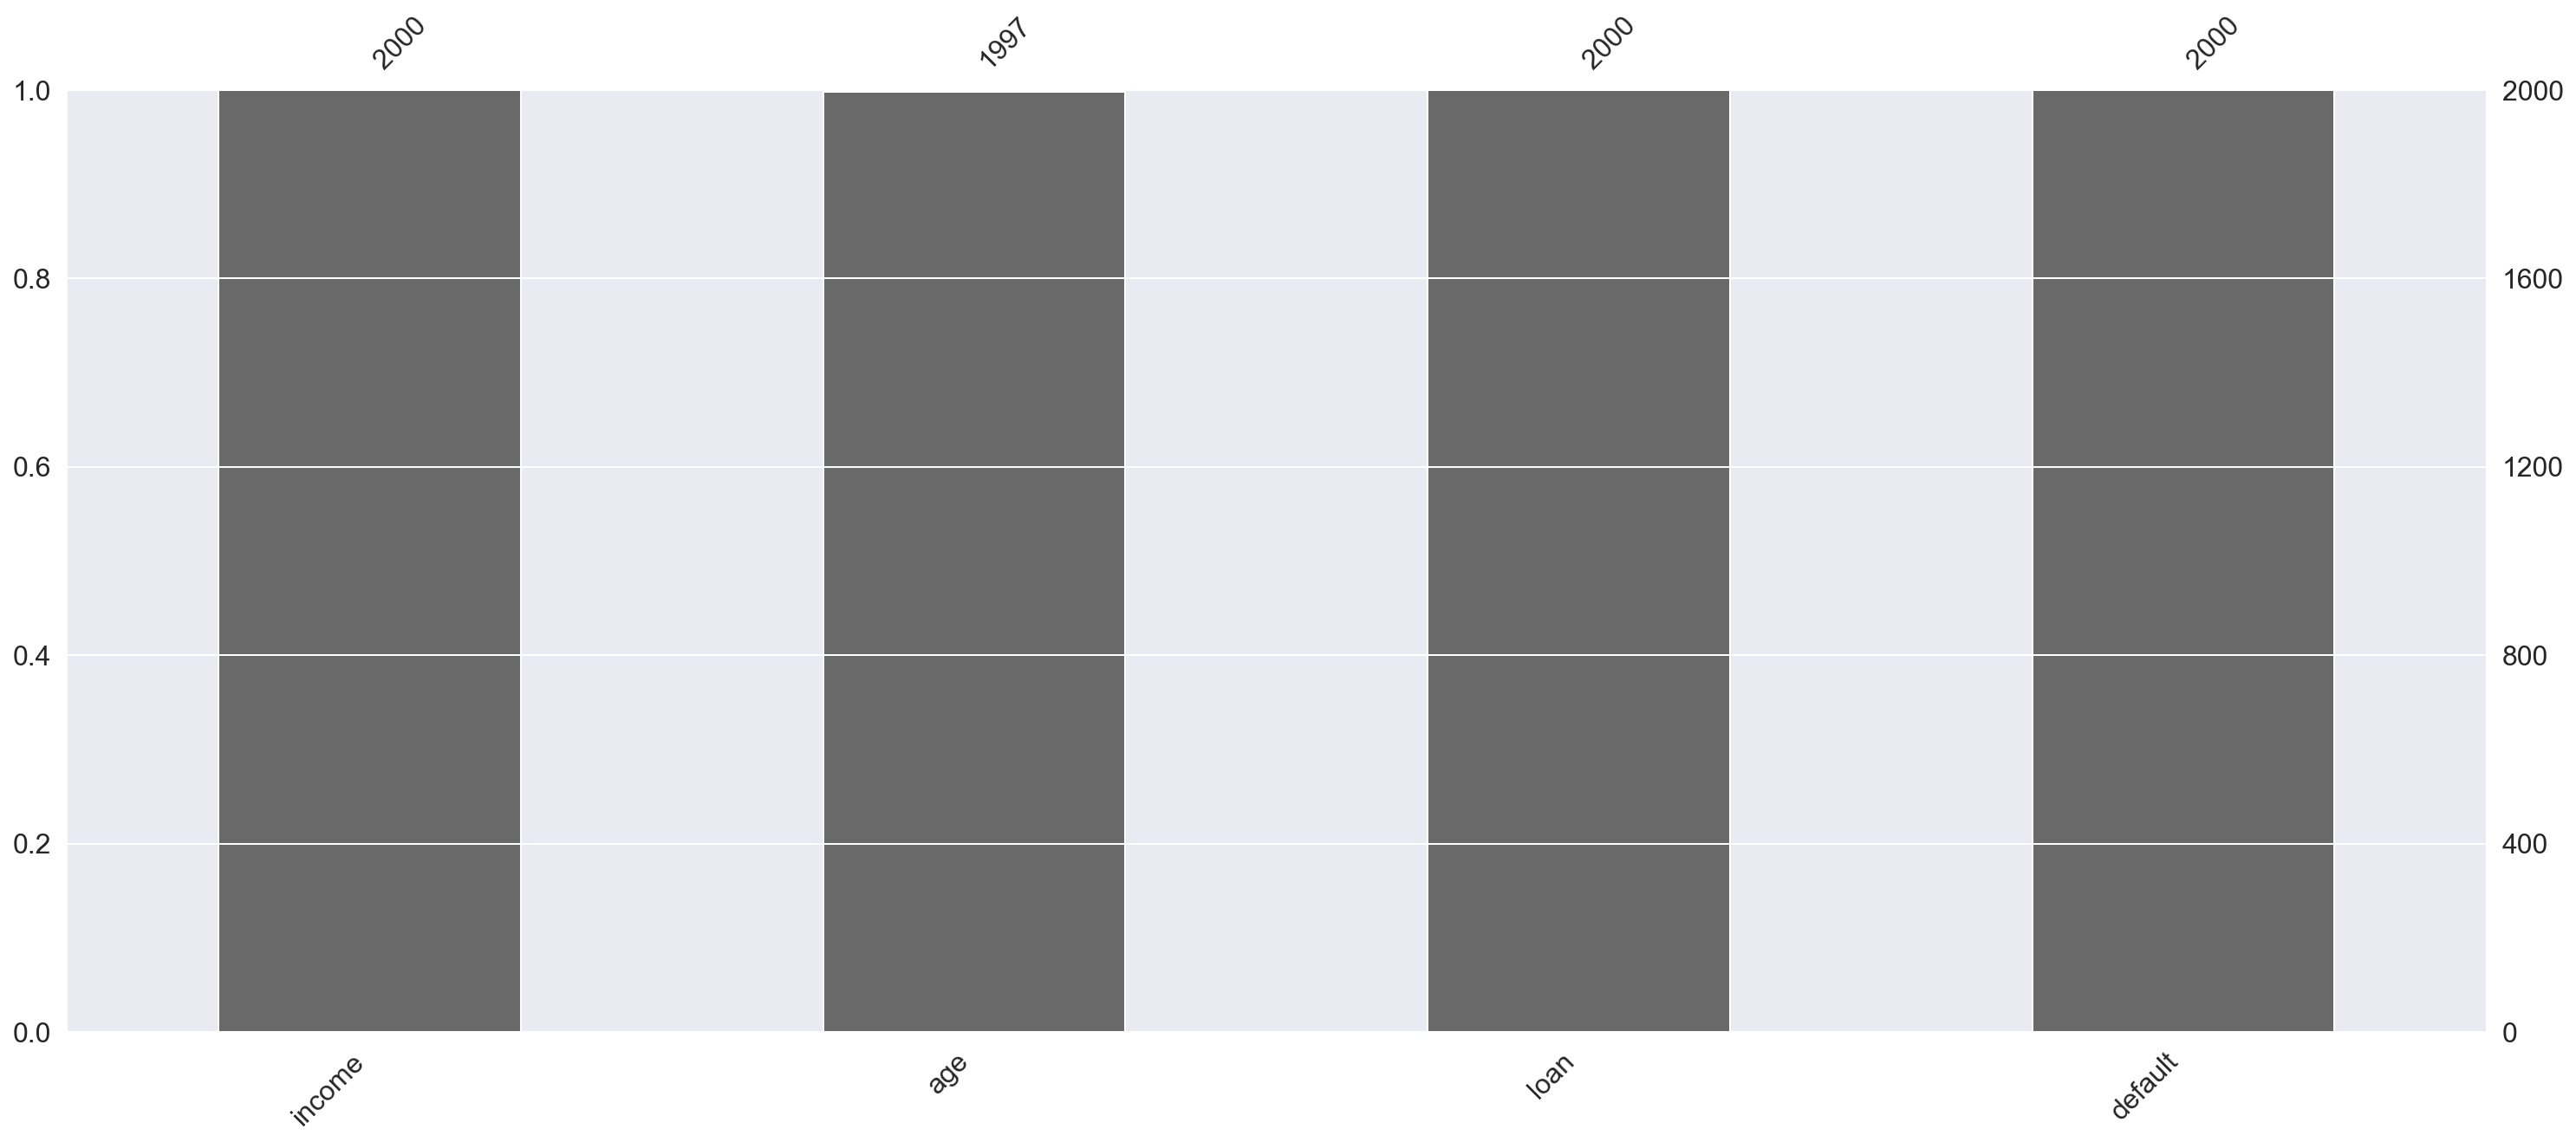

In [7]:
msno.bar(df)
plt.show()

It seems that there are not many missing values. It was difficult to distinguish only with the graphs, so I checked it with tables.<br>
I could check that there are only three missing values in the **Age** Column alone.

In [8]:
pd.isna(df).sum()

income     0
age        3
loan       0
default    0
dtype: int64

I took out the rows with the missing value in Age column and checked them. Because I wondered if there is any other weird discovery in those rows.<br>
However, I found nothing special. 

In [9]:
df.loc[pd.isna(df)["age"], ]

,income,age,loan,default
clientid,,,,
29,59417.80541,NaN,2082.625938,0
31,48528.85280,NaN,6155.784670,0
32,23526.30256,NaN,2862.010139,0


Since there are only three rows with missing values out of 2,000 rows, I actually thought it was okay to delete them. <br>
However, I thought it also wouldn't matter if I put a mean value on those, so I replaced those with a mean value.

In [10]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="mean")
df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)
df

,income,age,loan,default
0,66155.92510,59.017015,8106.532131,0.0
1,34415.15397,48.117153,6564.745018,0.0
2,57317.17006,63.108049,8020.953296,0.0
3,42709.53420,45.751972,6103.642260,0.0
4,66952.68885,18.584336,8770.099235,1.0
...,...,...,...,...
1995,59221.04487,48.518179,1926.729397,0.0
1996,69516.12757,23.162104,3503.176156,0.0
1997,44311.44926,28.017167,5522.786693,1.0
1998,43756.05660,63.971796,1622.722598,0.0


### Remove Outlier

DBScan

When the outlier was searched(with clustering methods), no outliers were observed.

In [14]:
X = df.drop('default', axis = 1)
X.shape

(2000, 3)

In [15]:
from scipy.spatial.distance import cdist
from sklearn.cluster import DBSCAN

In [16]:
DM = cdist(X, X)
np.quantile(DM, 0.1)

4226.169455917746

In [17]:
cluster_model = DBSCAN(eps = 4226, min_samples = 3).fit(X)
print(sum(cluster_model.labels_ == -1)) 

0


IQR

When I tried to find the outliers through IQR, several outliers were found.

In [19]:
X = df.drop('default', axis = 1)
X.shape

(2000, 3)

<AxesSubplot:>

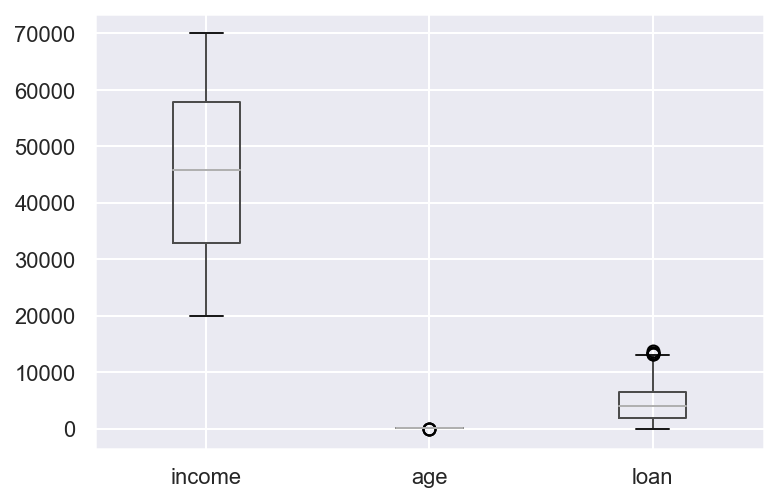

In [20]:
X.boxplot()

There are many functions to use, but I made a simple function to find an outlier.

In [21]:
import numpy as np
def IQR_rule(val_list): 
    Q1 = np.quantile(val_list, 0.25)
    Q3 = np.quantile(val_list, 0.75)
    IQR = Q3 - Q1
    
    not_outlier_condition = (Q3 + 1.5 * IQR > val_list) & (Q1 - 1.5 * IQR < val_list)
    return not_outlier_condition

In [22]:
conditions = X.apply(IQR_rule)
conditions.sum(axis=0)

income    2000
age       1997
loan      1995
dtype: int64

In [23]:
conditions["default"] = True
conditions

,income,age,loan,default
0,True,True,True,True
1,True,True,True,True
2,True,True,True,True
3,True,True,True,True
4,True,True,True,True
...,...,...,...,...
1995,True,True,True,True
1996,True,True,True,True
1997,True,True,True,True
1998,True,True,True,True


In [24]:
total_condition = conditions.sum(axis = 1) == len(df.columns) # remove rows which have more than 1 outliers
df = df.loc[total_condition] # remove outlier

Excluding outliers through IQR, 92 rows out of 2,000 remained.

In [25]:
df.shape

(1992, 4)

### Scaling

As can be seen from the boxplot above, there are huge scale difference between the variables. Therefore, scaling was performed.

In [26]:
X = df.drop("default", axis=1)
Y = df[["default"]]
X.head()

,income,age,loan
0,66155.92510,59.017015,8106.532131
1,34415.15397,48.117153,6564.745018
2,57317.17006,63.108049,8020.953296
3,42709.53420,45.751972,6103.642260
4,66952.68885,18.584336,8770.099235


In [27]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler().fit(X)
X = scaler.transform(X)

In [28]:
# When getting another data set, use this code to use minmax_scaler

Test_X = scaler.transform(Test_X)

In [29]:
X = pd.DataFrame(X, columns=df.columns[:3])

In [30]:
df_processed = pd.concat([X, Y], axis=1)
df_processed.head()

,income,age,loan,default
0,0.923176,0.892092,0.621542,0.0
1,0.288122,0.654708,0.503310,0.0
2,0.746334,0.981189,0.614979,0.0
3,0.454072,0.603198,0.467951,0.0
4,0.939117,0.011524,0.672427,1.0


### Test Train Split

In [31]:
from sklearn.model_selection import train_test_split
Train_X, Test_X, Train_Y, Test_Y = train_test_split(X, Y, test_size=0.3)
Train_X.shape

(1394, 3)

## Logistic Regression

First, I made model with the simple logistic regression. The basic model showed very high accuracy.

In [92]:
from sklearn.linear_model import LogisticRegression 

model= LogisticRegression(solver= 'lbfgs').fit(Train_X, Train_Y)

/Users/sanghyuk/anaconda/envs/py38/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Test Accuracy was 93.3%

In [94]:
print('Train Accuracy : ', model.score(Train_X, Train_Y))
print('Test Accuracy : ',model.score(Test_X, Test_Y))

Train Accuracy :  0.9375896700143472
Test Accuracy :  0.9331103678929766


More hyperparameters were explored together with GridSearch, including Lasso(L1) and Ridge(L2).

In [96]:
np.linspace(0, 10)

array([ 0.        ,  0.20408163,  0.40816327,  0.6122449 ,  0.81632653,
        1.02040816,  1.2244898 ,  1.42857143,  1.63265306,  1.83673469,
        2.04081633,  2.24489796,  2.44897959,  2.65306122,  2.85714286,
        3.06122449,  3.26530612,  3.46938776,  3.67346939,  3.87755102,
        4.08163265,  4.28571429,  4.48979592,  4.69387755,  4.89795918,
        5.10204082,  5.30612245,  5.51020408,  5.71428571,  5.91836735,
        6.12244898,  6.32653061,  6.53061224,  6.73469388,  6.93877551,
        7.14285714,  7.34693878,  7.55102041,  7.75510204,  7.95918367,
        8.16326531,  8.36734694,  8.57142857,  8.7755102 ,  8.97959184,
        9.18367347,  9.3877551 ,  9.59183673,  9.79591837, 10.        ])

In [98]:
from sklearn.model_selection import GridSearchCV

In [99]:
parameters = {'penalty':('l1', 'l2'), 'C':np.linspace(0, 10)}
model= LogisticRegression()
clf = GridSearchCV(model, parameters)
clf.fit(Train_X, Train_Y)

/Users/sanghyuk/anaconda/envs/py38/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sanghyuk/anaconda/envs/py38/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/sanghyuk/anaconda/envs/py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/sanghyuk/anaconda/envs/py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this t

/Users/sanghyuk/anaconda/envs/py38/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sanghyuk/anaconda/envs/py38/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/sanghyuk/anaconda/envs/py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/sanghyuk/anaconda/envs/py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this t

/Users/sanghyuk/anaconda/envs/py38/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/sanghyuk/anaconda/envs/py38/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/sanghyuk/anaconda/envs/py38/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sanghyuk/anaconda/envs/py38/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_t

/Users/sanghyuk/anaconda/envs/py38/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/sanghyuk/anaconda/envs/py38/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/sanghyuk/anaconda/envs/py38/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sanghyuk/anaconda/envs/py38/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_t

/Users/sanghyuk/anaconda/envs/py38/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/sanghyuk/anaconda/envs/py38/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/sanghyuk/anaconda/envs/py38/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/sanghyuk/anaconda/envs/py38/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on thi

/Users/sanghyuk/anaconda/envs/py38/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/sanghyuk/anaconda/envs/py38/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sanghyuk/anaconda/envs/py38/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/sanghyuk/anaconda/envs/py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/sanghyuk/anaconda/envs/py38/lib/python3.8/site-package

/Users/sanghyuk/anaconda/envs/py38/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sanghyuk/anaconda/envs/py38/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/sanghyuk/anaconda/envs/py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/sanghyuk/anaconda/envs/py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this t

/Users/sanghyuk/anaconda/envs/py38/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/sanghyuk/anaconda/envs/py38/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sanghyuk/anaconda/envs/py38/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/sanghyuk/anaconda/envs/py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/sanghyuk/anaconda/envs/py38/lib/python3.8/site-package

/Users/sanghyuk/anaconda/envs/py38/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/sanghyuk/anaconda/envs/py38/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/sanghyuk/anaconda/envs/py38/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/sanghyuk/anaconda/envs/py38/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array 

/Users/sanghyuk/anaconda/envs/py38/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/sanghyuk/anaconda/envs/py38/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/sanghyuk/anaconda/envs/py38/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sanghyuk/anaconda/envs/py38/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_t

/Users/sanghyuk/anaconda/envs/py38/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sanghyuk/anaconda/envs/py38/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/sanghyuk/anaconda/envs/py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/sanghyuk/anaconda/envs/py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this t

/Users/sanghyuk/anaconda/envs/py38/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/sanghyuk/anaconda/envs/py38/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/sanghyuk/anaconda/envs/py38/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sanghyuk/anaconda/envs/py38/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_t

/Users/sanghyuk/anaconda/envs/py38/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/sanghyuk/anaconda/envs/py38/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/sanghyuk/anaconda/envs/py38/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/sanghyuk/anaconda/envs/py38/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array 

/Users/sanghyuk/anaconda/envs/py38/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/sanghyuk/anaconda/envs/py38/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/sanghyuk/anaconda/envs/py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/sanghyuk/anaconda/envs/py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this t

/Users/sanghyuk/anaconda/envs/py38/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/sanghyuk/anaconda/envs/py38/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/sanghyuk/anaconda/envs/py38/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/sanghyuk/anaconda/envs/py38/lib/python3.8/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: 

GridSearchCV(estimator=LogisticRegression(),
             param_grid={'C': array([ 0.        ,  0.20408163,  0.40816327,  0.6122449 ,  0.81632653,
        1.02040816,  1.2244898 ,  1.42857143,  1.63265306,  1.83673469,
        2.04081633,  2.24489796,  2.44897959,  2.65306122,  2.85714286,
        3.06122449,  3.26530612,  3.46938776,  3.67346939,  3.87755102,
        4.08163265,  4.28571429,  4.48979592,  4.69387755,  4.89795918,
        5.10204082,  5.30612245,  5.51020408,  5.71428571,  5.91836735,
        6.12244898,  6.32653061,  6.53061224,  6.73469388,  6.93877551,
        7.14285714,  7.34693878,  7.55102041,  7.75510204,  7.95918367,
        8.16326531,  8.36734694,  8.57142857,  8.7755102 ,  8.97959184,
        9.18367347,  9.3877551 ,  9.59183673,  9.79591837, 10.        ]),
                         'penalty': ('l1', 'l2')})

The below cell shows best parameters found by grid search. 

In [101]:
clf.best_params_

{'C': 3.8775510204081636, 'penalty': 'l2'}

In [102]:
from sklearn.linear_model import LogisticRegression 

model= LogisticRegression(C=3.8775510204081636, penalty='l2').fit(Train_X, Train_Y)

/Users/sanghyuk/anaconda/envs/py38/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [103]:
print('Test Accuracy : ',model.score(Test_X, Test_Y))

Test Accuracy :  0.9381270903010034


In [104]:
from sklearn.metrics import confusion_matrix

confusion_matrix(model.predict(Test_X), Test_Y)

array([[504,  27],
       [ 10,  57]])

In [106]:
from sklearn.metrics import classification_report

print(classification_report(model.predict(Test_X), Test_Y))

              precision    recall  f1-score   support

         0.0       0.98      0.95      0.96       531
         1.0       0.68      0.85      0.75        67

    accuracy                           0.94       598
   macro avg       0.83      0.90      0.86       598
weighted avg       0.95      0.94      0.94       598



Final model with l2 norm penalty(Ridge) and C 3.877 shows the test accuracy as 0.938

In [113]:
X.shape

(1992, 3)

In [117]:
model.coef_.T.reshape(-1)

array([-5.9748084 , -9.45368463, 12.0585913 ])

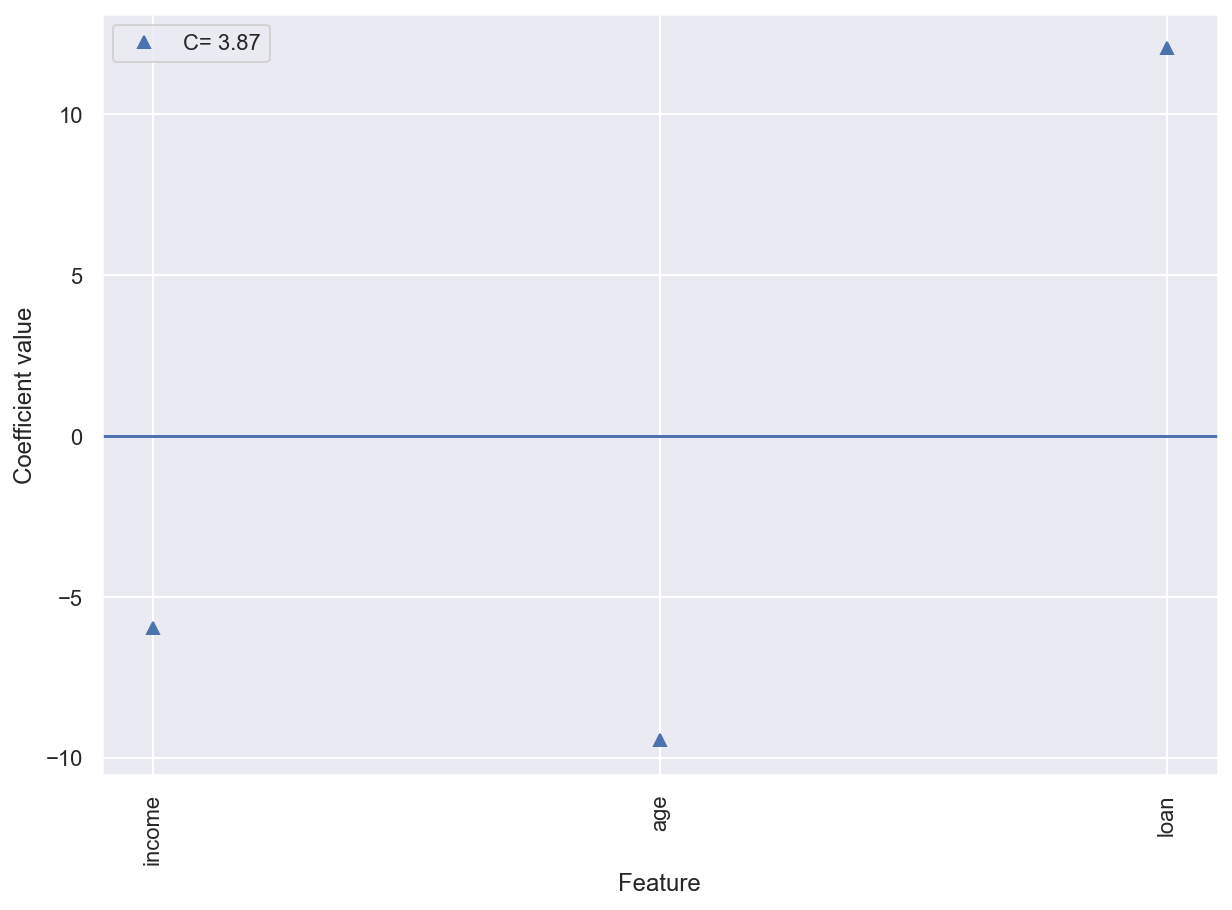

In [124]:
plt.figure(figsize= (10,7))

plt.plot(model.coef_.T, '^b', label="C= 3.87")
plt.xticks(range(X.shape[1]), X.columns, rotation=90)

xlims = plt.xlim()
plt.hlines(0, xlims[0], xlims[1])
plt.xlim(xlims)
plt.xlabel("Feature")
plt.ylabel("Coefficient value")
plt.legend()

The above graph shows values of the coef from my final model. In fact, I tried to draw this graph to use when we check the l1(Lasso) Regression. However, grid search shows l2 is better. 

## Random Forest

Next, I tried Random Forest. Random Forest is widely used to this kind of classification problem. With only the most basic model, the train acuracy was 100%. However, since this is an excessively overfitted value, grid search was also performed to find the optimal parameter. 

In [201]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(random_state=123)
model.fit(Train_X, Train_Y)

train_acc = model.score(Train_X, Train_Y)
test_acc = model.score(Test_X, Test_Y)

print(f'Train Accuracy: {train_acc:.3f}')
print(f'Test Accuracy: {test_acc:.3f}')

<ipython-input-201-333b1ee50696>:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(Train_X, Train_Y)


Train Accuracy: 1.000
Test Accuracy: 0.992


In [202]:
estimator = RandomForestClassifier(random_state=123)

max_depth = [ depth for depth in range(1, 8) ]
min_split = [ split for split in range(1, 10) ]
trees = [ tree *10 for tree in range(1, 11) ]

param_grids = {"max_depth": max_depth,
             "min_samples_split": min_split,
             "n_estimators":trees}

model_grid = GridSearchCV(estimator, param_grid=param_grids, scoring="accuracy", n_jobs = -1)
model_grid.fit(Train_X, Train_Y)

print("best estimator: {}".format(model_grid.best_estimator_))
print("best parameters: {}".format(model_grid.best_params_))
print("best score: {}".format(model_grid.best_score_.round(3)))

best estimator: RandomForestClassifier(max_depth=7, min_samples_split=3, n_estimators=80,
                       random_state=123)
best parameters: {'max_depth': 7, 'min_samples_split': 3, 'n_estimators': 80}
best score: 0.978


/Users/sanghyuk/anaconda/envs/py38/lib/python3.8/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan 0.85939764 0.85939764
 0.85939764 0.85939764 0.85939764 0.85939764 0.85939764 0.85939764
 0.85939764 0.85939764 0.85939764 0.85939764 0.85939764 0.85939764
 0.85939764 0.85939764 0.85939764 0.85939764 0.85939764 0.85939764
 0.85939764 0.85939764 0.85939764 0.85939764 0.85939764 0.85939764
 0.85939764 0.85939764 0.85939764 0.85939764 0.85939764 0.85939764
 0.85939764 0.85939764 0.85939764 0.85939764 0.85939764 0.85939764
 0.85939764 0.85939764 0.85939764 0.85939764 0.85939764 0.85939764
 0.85939764 0.85939764 0.85939764 0.85939764 0.85939764 0.85939764
 0.85939764 0.85939764 0.85939764 0.85939764 0.85939764 0.85939764
 0.85939764 0.85939764 0.85939764 0.85939764 0.85939764 0.85939764
 0.85939764 0.85939764 0.85939764

I've tried to find optimal parameter(max_depth, min_split, number of trees) with Grid Search. It showed max_depth 7, min_split 3, number of trees 80 is the most great hyperparameters

In [203]:
model_grid.best_params_

{'max_depth': 7, 'min_samples_split': 3, 'n_estimators': 80}

In [205]:
model_opt = RandomForestClassifier(max_depth= 7,
             min_samples_split=3,
             n_estimators= 80 ,random_state=123)
model_opt.fit(Train_X, Train_Y)

train_acc = model_opt.score(Train_X, Train_Y)
test_acc = model_opt.score(Test_X, Test_Y)

print(f'Train Accuracy: {train_acc:.3f}')
print(f'Test Accuracy: {test_acc:.3f}')

Train Accuracy: 0.999
Test Accuracy: 0.992


<ipython-input-205-559b27428653>:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model_opt.fit(Train_X, Train_Y)


In [206]:
from sklearn.metrics import classification_report

print(classification_report(model_opt.predict(Test_X), Test_Y))

              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00       518
         1.0       0.94      1.00      0.97        80

    accuracy                           0.99       598
   macro avg       0.97      1.00      0.98       598
weighted avg       0.99      0.99      0.99       598



Accuracy with test data shows 0.99. It shows more accurate model than Logistic Regression. 

I tried Gradient Boosting. Because Gradient Boosting algorithm keep finding the weak learners(trees) with the errors as target values, I though this model also can be adequate to this classfier problem. 

In [207]:
from sklearn.ensemble import GradientBoostingClassifier

model_grad = GradientBoostingClassifier(n_estimators=100, max_depth=2, random_state=0)

I also use grid search to fin optimal hyperparameters. It shows 90 weak learners which have 6 max_depth will be the best model.

In [208]:
estimator = GradientBoostingClassifier(random_state=123)

max_depth = [ depth for depth in range(1, 8) ]
trees = [ tree *10 for tree in range(1, 11) ]

param_grids = {"max_depth": max_depth,
             "n_estimators":trees}

model_grid = GridSearchCV(estimator, param_grid=param_grids, scoring="accuracy", n_jobs = -1)
model_grid.fit(Train_X, Train_Y)

print("best estimator: {}".format(model_grid.best_estimator_))
print("best parameters: {}".format(model_grid.best_params_))
print("best score: {}".format(model_grid.best_score_.round(3)))

best estimator: GradientBoostingClassifier(max_depth=6, n_estimators=90, random_state=123)
best parameters: {'max_depth': 6, 'n_estimators': 90}
best score: 0.989


/Users/sanghyuk/anaconda/envs/py38/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [209]:
model_opt = GradientBoostingClassifier(max_depth= 6,
             n_estimators= 90 ,random_state=123)
model_opt.fit(Train_X, Train_Y)

train_acc = model_opt.score(Train_X, Train_Y)
test_acc = model_opt.score(Test_X, Test_Y)

print(f'Train Accuracy: {train_acc:.3f}')
print(f'Test Accuracy: {test_acc:.3f}')

/Users/sanghyuk/anaconda/envs/py38/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Train Accuracy: 1.000
Test Accuracy: 0.988


In [210]:
from sklearn.metrics import classification_report

print(classification_report(model_opt.predict(Test_X), Test_Y))

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99       512
         1.0       0.96      0.95      0.96        86

    accuracy                           0.99       598
   macro avg       0.98      0.97      0.98       598
weighted avg       0.99      0.99      0.99       598



Gradient Boosting model shows 99% accuracy. 

## SVM

I tried SVM model. SVM is a very widely used model in classification problems. <br>
To be exact, I have to say I tried Kernel SVM model, because rbf kernel is set in the scikit-learn svm API as default. 

In [135]:
from sklearn.svm import SVC

In [138]:
def train_acc(C_value, gamma_value):
    
    svc_final = SVC(kernel= 'rbf' ,gamma = gamma_value , C = C_value , random_state=1234)
    svc_final.fit(Train_X, Train_Y)
    
   # Validation
    y_pred = svc_final.predict(Test_X)
    acc= svc_final.score(Test_X, Test_Y)
    
    return acc

This time, I tried to find optimal hyperparameters with bayesian optimization. I found gamma 8.091, and C 8.702 are the best parameters. 

In [140]:
from bayes_opt import BayesianOptimization

pbounds = {'C_value': (0.01, 10) , 'gamma_value': (0.01, 10) } # 범위 설정

optimizer = BayesianOptimization(
    f=train_acc ,
    pbounds=pbounds ,
    random_state=1)

optimizer.maximize(init_points=5 , n_iter= 50 )  #n_iter 초기 point를 제외하고 시행할 횟수 purples are maximize value.-> we can use final value.

|   iter    |  target   |  C_value  | gamma_... |
-------------------------------------------------
|  1        |  0.9849   |  4.176    |  7.206    |
|  2        |  0.8595   |  0.01114  |  3.03     |
|  3        |  0.9649   |  1.476    |  0.9325   |


/Users/sanghyuk/anaconda/envs/py38/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/sanghyuk/anaconda/envs/py38/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/sanghyuk/anaconda/envs/py38/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/sanghyuk/anaconda/envs/py38/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array 

|  4        |  0.9799   |  1.871    |  3.462    |
|  5        |  0.9883   |  3.974    |  5.393    |
|  6        |  0.9883   |  3.812    |  5.573    |


/Users/sanghyuk/anaconda/envs/py38/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/sanghyuk/anaconda/envs/py38/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/sanghyuk/anaconda/envs/py38/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/sanghyuk/anaconda/envs/py38/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array 

|  7        |  0.9833   |  3.719    |  2.931    |
|  8        |  0.9849   |  6.612    |  6.282    |


/Users/sanghyuk/anaconda/envs/py38/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/sanghyuk/anaconda/envs/py38/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


|  9        |  0.99     |  6.403    |  8.862    |
|  10       |  0.9916   |  8.702    |  8.091    |


/Users/sanghyuk/anaconda/envs/py38/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/sanghyuk/anaconda/envs/py38/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


|  11       |  0.9866   |  9.515    |  5.76     |
|  12       |  0.9883   |  10.0     |  10.0     |


/Users/sanghyuk/anaconda/envs/py38/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/sanghyuk/anaconda/envs/py38/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


|  13       |  0.99     |  4.032    |  10.0     |
|  14       |  0.9732   |  1.666    |  9.022    |


/Users/sanghyuk/anaconda/envs/py38/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/sanghyuk/anaconda/envs/py38/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


|  15       |  0.9916   |  7.849    |  9.992    |
|  16       |  0.9866   |  7.884    |  3.294    |


/Users/sanghyuk/anaconda/envs/py38/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/sanghyuk/anaconda/envs/py38/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


|  17       |  0.9866   |  10.0     |  1.574    |
|  18       |  0.9682   |  7.458    |  0.4606   |


/Users/sanghyuk/anaconda/envs/py38/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/sanghyuk/anaconda/envs/py38/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


|  19       |  0.9866   |  10.0     |  3.687    |
|  20       |  0.9314   |  4.264    |  0.04     |


/Users/sanghyuk/anaconda/envs/py38/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/sanghyuk/anaconda/envs/py38/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


|  21       |  0.9883   |  5.956    |  4.023    |
|  22       |  0.9783   |  1.626    |  6.384    |


/Users/sanghyuk/anaconda/envs/py38/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/sanghyuk/anaconda/envs/py38/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


|  23       |  0.9064   |  0.03181  |  9.995    |
|  24       |  0.9247   |  9.958    |  0.01201  |


/Users/sanghyuk/anaconda/envs/py38/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/sanghyuk/anaconda/envs/py38/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


|  25       |  0.9833   |  7.896    |  5.034    |
|  26       |  0.9916   |  10.0     |  7.619    |


/Users/sanghyuk/anaconda/envs/py38/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/sanghyuk/anaconda/envs/py38/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


|  27       |  0.9816   |  2.81     |  4.454    |
|  28       |  0.99     |  5.676    |  10.0     |


/Users/sanghyuk/anaconda/envs/py38/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/sanghyuk/anaconda/envs/py38/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


|  29       |  0.9849   |  3.196    |  8.477    |
|  30       |  0.9866   |  6.244    |  2.282    |


/Users/sanghyuk/anaconda/envs/py38/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/sanghyuk/anaconda/envs/py38/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


|  31       |  0.9849   |  8.88     |  2.188    |
|  32       |  0.99     |  8.128    |  6.858    |


/Users/sanghyuk/anaconda/envs/py38/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/sanghyuk/anaconda/envs/py38/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


|  33       |  0.99     |  5.012    |  8.628    |
|  34       |  0.99     |  9.998    |  8.86     |


/Users/sanghyuk/anaconda/envs/py38/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/sanghyuk/anaconda/envs/py38/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


|  35       |  0.99     |  7.149    |  7.781    |
|  36       |  0.9883   |  10.0     |  2.561    |


/Users/sanghyuk/anaconda/envs/py38/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/sanghyuk/anaconda/envs/py38/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


|  37       |  0.9849   |  5.206    |  5.985    |
|  38       |  0.9783   |  2.603    |  2.366    |


/Users/sanghyuk/anaconda/envs/py38/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/sanghyuk/anaconda/envs/py38/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


|  39       |  0.9916   |  8.869    |  9.484    |
|  40       |  0.9766   |  2.368    |  7.442    |


/Users/sanghyuk/anaconda/envs/py38/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/sanghyuk/anaconda/envs/py38/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


|  41       |  0.9849   |  2.756    |  9.899    |
|  42       |  0.99     |  5.734    |  7.471    |


/Users/sanghyuk/anaconda/envs/py38/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/sanghyuk/anaconda/envs/py38/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


|  43       |  0.9849   |  5.078    |  3.276    |
|  44       |  0.9916   |  7.746    |  8.937    |


/Users/sanghyuk/anaconda/envs/py38/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/sanghyuk/anaconda/envs/py38/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


|  45       |  0.9866   |  7.472    |  2.099    |
|  46       |  0.8595   |  0.01     |  0.01     |


/Users/sanghyuk/anaconda/envs/py38/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


|  47       |  0.8595   |  0.01275  |  6.874    |
|  48       |  0.9799   |  2.462    |  5.899    |


/Users/sanghyuk/anaconda/envs/py38/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/sanghyuk/anaconda/envs/py38/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


|  49       |  0.9883   |  6.756    |  3.266    |
|  50       |  0.99     |  10.0     |  6.565    |


/Users/sanghyuk/anaconda/envs/py38/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/sanghyuk/anaconda/envs/py38/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


|  51       |  0.9916   |  6.741    |  9.996    |
|  52       |  0.9833   |  10.0     |  4.914    |


/Users/sanghyuk/anaconda/envs/py38/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/sanghyuk/anaconda/envs/py38/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


|  53       |  0.99     |  9.161    |  6.95     |
|  54       |  0.9849   |  8.914    |  4.108    |
|  55       |  0.9866   |  4.256    |  4.074    |


/Users/sanghyuk/anaconda/envs/py38/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/sanghyuk/anaconda/envs/py38/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [143]:
svc_final = SVC(kernel= 'rbf',  gamma = 8.091  ,  C =  8.702, random_state=1234)
svc_final.fit(Train_X, Train_Y)

# Validation
y_pred = svc_final.predict(Test_X)

# train data set accuracy
print("Train Accuracy: {:.3f}".format(svc_final.score(Train_X, Train_Y)))
# test data set accuracy
print("Test Accuracy: {:.3f}\n".format(svc_final.score(Test_X, Test_Y)))
# confusion matrix
print("Confusion matrix: \n{}".format(confusion_matrix(Test_Y, y_pred)))

Train Accuracy: 0.993
Test Accuracy: 0.992

Confusion matrix: 
[[513   1]
 [  4  80]]


/Users/sanghyuk/anaconda/envs/py38/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [145]:
from sklearn.metrics import classification_report

print(classification_report(svc_final.predict(Test_X), Test_Y))b

              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00       517
         1.0       0.95      0.99      0.97        81

    accuracy                           0.99       598
   macro avg       0.98      0.99      0.98       598
weighted avg       0.99      0.99      0.99       598



Test Accuracy was measures 99% with test data.

## Neural Net

I've tried Neural Network Classifier. 

In [36]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Dropout



model3 = Sequential()
model3.add(Dense(10, input_dim=3, activation="relu"))
model3.add(Dense(10, activation="relu"))
model3.add(Dense(1, activation="relu"))

model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=["accuracy"])

In [37]:
%%time
hist = model3.fit(Train_X, Train_Y,
                 epochs=500, batch_size=100,
                 validation_data=(Test_X, Test_Y),
                 verbose=2)

Epoch 1/500
14/14 - 1s - loss: 0.6191 - accuracy: 0.8608 - val_loss: 0.5412 - val_accuracy: 0.8545
Epoch 2/500
14/14 - 0s - loss: 0.5043 - accuracy: 0.8608 - val_loss: 0.5045 - val_accuracy: 0.8545
Epoch 3/500
14/14 - 0s - loss: 0.4766 - accuracy: 0.8608 - val_loss: 0.4812 - val_accuracy: 0.8545
Epoch 4/500
14/14 - 0s - loss: 0.4569 - accuracy: 0.8608 - val_loss: 0.4611 - val_accuracy: 0.8545
Epoch 5/500
14/14 - 0s - loss: 0.4393 - accuracy: 0.8608 - val_loss: 0.4431 - val_accuracy: 0.8545
Epoch 6/500
14/14 - 0s - loss: 0.4234 - accuracy: 0.8608 - val_loss: 0.4257 - val_accuracy: 0.8545
Epoch 7/500
14/14 - 0s - loss: 0.4087 - accuracy: 0.8608 - val_loss: 0.4096 - val_accuracy: 0.8545
Epoch 8/500
14/14 - 0s - loss: 0.3942 - accuracy: 0.8608 - val_loss: 0.3950 - val_accuracy: 0.8545
Epoch 9/500
14/14 - 0s - loss: 0.3812 - accuracy: 0.8608 - val_loss: 0.3806 - val_accuracy: 0.8545
Epoch 10/500
14/14 - 0s - loss: 0.3678 - accuracy: 0.8608 - val_loss: 0.3662 - val_accuracy: 0.8545
Epoch 11/

14/14 - 0s - loss: 0.1024 - accuracy: 0.9519 - val_loss: 0.0983 - val_accuracy: 0.9532
Epoch 84/500
14/14 - 0s - loss: 0.1021 - accuracy: 0.9519 - val_loss: 0.0979 - val_accuracy: 0.9548
Epoch 85/500
14/14 - 0s - loss: 0.1017 - accuracy: 0.9527 - val_loss: 0.0976 - val_accuracy: 0.9532
Epoch 86/500
14/14 - 0s - loss: 0.1015 - accuracy: 0.9519 - val_loss: 0.0978 - val_accuracy: 0.9548
Epoch 87/500
14/14 - 0s - loss: 0.1014 - accuracy: 0.9519 - val_loss: 0.0976 - val_accuracy: 0.9548
Epoch 88/500
14/14 - 0s - loss: 0.1012 - accuracy: 0.9519 - val_loss: 0.0965 - val_accuracy: 0.9532
Epoch 89/500
14/14 - 0s - loss: 0.1005 - accuracy: 0.9527 - val_loss: 0.0969 - val_accuracy: 0.9548
Epoch 90/500
14/14 - 0s - loss: 0.1001 - accuracy: 0.9541 - val_loss: 0.0966 - val_accuracy: 0.9548
Epoch 91/500
14/14 - 0s - loss: 0.0998 - accuracy: 0.9534 - val_loss: 0.0962 - val_accuracy: 0.9548
Epoch 92/500
14/14 - 0s - loss: 0.0996 - accuracy: 0.9527 - val_loss: 0.0954 - val_accuracy: 0.9532
Epoch 93/500


Epoch 165/500
14/14 - 0s - loss: 0.0593 - accuracy: 0.9770 - val_loss: 0.0602 - val_accuracy: 0.9682
Epoch 166/500
14/14 - 0s - loss: 0.0588 - accuracy: 0.9763 - val_loss: 0.0602 - val_accuracy: 0.9699
Epoch 167/500
14/14 - 0s - loss: 0.0585 - accuracy: 0.9742 - val_loss: 0.0601 - val_accuracy: 0.9699
Epoch 168/500
14/14 - 0s - loss: 0.0583 - accuracy: 0.9763 - val_loss: 0.0590 - val_accuracy: 0.9699
Epoch 169/500
14/14 - 0s - loss: 0.0576 - accuracy: 0.9770 - val_loss: 0.0588 - val_accuracy: 0.9682
Epoch 170/500
14/14 - 0s - loss: 0.0573 - accuracy: 0.9763 - val_loss: 0.0589 - val_accuracy: 0.9699
Epoch 171/500
14/14 - 0s - loss: 0.0571 - accuracy: 0.9770 - val_loss: 0.0581 - val_accuracy: 0.9699
Epoch 172/500
14/14 - 0s - loss: 0.0571 - accuracy: 0.9756 - val_loss: 0.0584 - val_accuracy: 0.9699
Epoch 173/500
14/14 - 0s - loss: 0.0562 - accuracy: 0.9756 - val_loss: 0.0570 - val_accuracy: 0.9699
Epoch 174/500
14/14 - 0s - loss: 0.0558 - accuracy: 0.9785 - val_loss: 0.0573 - val_accurac

14/14 - 0s - loss: 0.0394 - accuracy: 0.9864 - val_loss: 0.0429 - val_accuracy: 0.9816
Epoch 247/500
14/14 - 0s - loss: 0.0394 - accuracy: 0.9849 - val_loss: 0.0430 - val_accuracy: 0.9799
Epoch 248/500
14/14 - 0s - loss: 0.0392 - accuracy: 0.9857 - val_loss: 0.0431 - val_accuracy: 0.9783
Epoch 249/500
14/14 - 0s - loss: 0.0389 - accuracy: 0.9864 - val_loss: 0.0422 - val_accuracy: 0.9833
Epoch 250/500
14/14 - 0s - loss: 0.0391 - accuracy: 0.9849 - val_loss: 0.0422 - val_accuracy: 0.9833
Epoch 251/500
14/14 - 0s - loss: 0.0387 - accuracy: 0.9857 - val_loss: 0.0425 - val_accuracy: 0.9799
Epoch 252/500
14/14 - 0s - loss: 0.0387 - accuracy: 0.9864 - val_loss: 0.0422 - val_accuracy: 0.9816
Epoch 253/500
14/14 - 0s - loss: 0.0386 - accuracy: 0.9864 - val_loss: 0.0423 - val_accuracy: 0.9833
Epoch 254/500
14/14 - 0s - loss: 0.0383 - accuracy: 0.9864 - val_loss: 0.0421 - val_accuracy: 0.9833
Epoch 255/500
14/14 - 0s - loss: 0.0380 - accuracy: 0.9864 - val_loss: 0.0415 - val_accuracy: 0.9849
Epoc

Epoch 328/500
14/14 - 0s - loss: 0.0303 - accuracy: 0.9907 - val_loss: 0.0344 - val_accuracy: 0.9866
Epoch 329/500
14/14 - 0s - loss: 0.0294 - accuracy: 0.9921 - val_loss: 0.0323 - val_accuracy: 0.9900
Epoch 330/500
14/14 - 0s - loss: 0.0298 - accuracy: 0.9907 - val_loss: 0.0323 - val_accuracy: 0.9900
Epoch 331/500
14/14 - 0s - loss: 0.0295 - accuracy: 0.9935 - val_loss: 0.0329 - val_accuracy: 0.9866
Epoch 332/500
14/14 - 0s - loss: 0.0294 - accuracy: 0.9921 - val_loss: 0.0325 - val_accuracy: 0.9883
Epoch 333/500
14/14 - 0s - loss: 0.0294 - accuracy: 0.9921 - val_loss: 0.0324 - val_accuracy: 0.9883
Epoch 334/500
14/14 - 0s - loss: 0.0294 - accuracy: 0.9914 - val_loss: 0.0319 - val_accuracy: 0.9883
Epoch 335/500
14/14 - 0s - loss: 0.0294 - accuracy: 0.9928 - val_loss: 0.0319 - val_accuracy: 0.9900
Epoch 336/500
14/14 - 0s - loss: 0.0294 - accuracy: 0.9921 - val_loss: 0.0318 - val_accuracy: 0.9883
Epoch 337/500
14/14 - 0s - loss: 0.0290 - accuracy: 0.9907 - val_loss: 0.0313 - val_accurac

14/14 - 0s - loss: 0.0230 - accuracy: 0.9935 - val_loss: 0.0250 - val_accuracy: 0.9933
Epoch 410/500
14/14 - 0s - loss: 0.0232 - accuracy: 0.9928 - val_loss: 0.0249 - val_accuracy: 0.9933
Epoch 411/500
14/14 - 0s - loss: 0.0232 - accuracy: 0.9921 - val_loss: 0.0259 - val_accuracy: 0.9950
Epoch 412/500
14/14 - 0s - loss: 0.0226 - accuracy: 0.9928 - val_loss: 0.0252 - val_accuracy: 0.9933
Epoch 413/500
14/14 - 0s - loss: 0.0227 - accuracy: 0.9935 - val_loss: 0.0247 - val_accuracy: 0.9933
Epoch 414/500
14/14 - 0s - loss: 0.0229 - accuracy: 0.9921 - val_loss: 0.0252 - val_accuracy: 0.9933
Epoch 415/500
14/14 - 0s - loss: 0.0225 - accuracy: 0.9935 - val_loss: 0.0247 - val_accuracy: 0.9933
Epoch 416/500
14/14 - 0s - loss: 0.0222 - accuracy: 0.9921 - val_loss: 0.0248 - val_accuracy: 0.9933
Epoch 417/500
14/14 - 0s - loss: 0.0225 - accuracy: 0.9950 - val_loss: 0.0248 - val_accuracy: 0.9933
Epoch 418/500
14/14 - 0s - loss: 0.0221 - accuracy: 0.9943 - val_loss: 0.0254 - val_accuracy: 0.9933
Epoc

Epoch 491/500
14/14 - 0s - loss: 0.0178 - accuracy: 0.9950 - val_loss: 0.0195 - val_accuracy: 0.9933
Epoch 492/500
14/14 - 0s - loss: 0.0181 - accuracy: 0.9950 - val_loss: 0.0190 - val_accuracy: 0.9950
Epoch 493/500
14/14 - 0s - loss: 0.0180 - accuracy: 0.9935 - val_loss: 0.0191 - val_accuracy: 0.9950
Epoch 494/500
14/14 - 0s - loss: 0.0178 - accuracy: 0.9957 - val_loss: 0.0195 - val_accuracy: 0.9933
Epoch 495/500
14/14 - 0s - loss: 0.0178 - accuracy: 0.9950 - val_loss: 0.0194 - val_accuracy: 0.9950
Epoch 496/500
14/14 - 0s - loss: 0.0177 - accuracy: 0.9957 - val_loss: 0.0192 - val_accuracy: 0.9933
Epoch 497/500
14/14 - 0s - loss: 0.0176 - accuracy: 0.9950 - val_loss: 0.0189 - val_accuracy: 0.9933
Epoch 498/500
14/14 - 0s - loss: 0.0174 - accuracy: 0.9957 - val_loss: 0.0192 - val_accuracy: 0.9933
Epoch 499/500
14/14 - 0s - loss: 0.0177 - accuracy: 0.9957 - val_loss: 0.0191 - val_accuracy: 0.9933
Epoch 500/500
14/14 - 0s - loss: 0.0174 - accuracy: 0.9950 - val_loss: 0.0189 - val_accurac

In [38]:
model3.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 10)                40        
_________________________________________________________________
dense_10 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 11        
Total params: 161
Trainable params: 161
Non-trainable params: 0
_________________________________________________________________


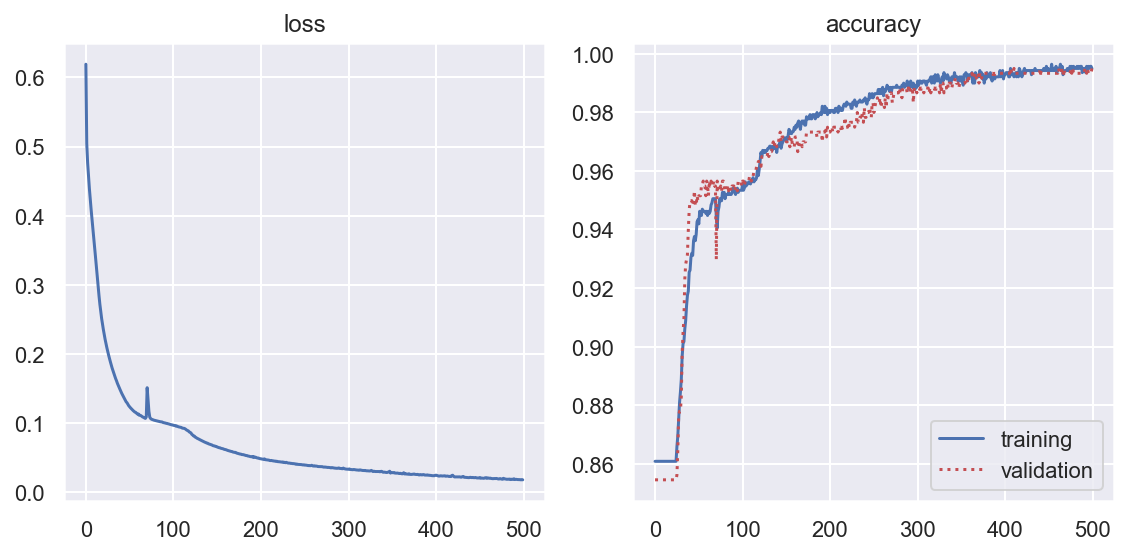

In [39]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(hist.history['loss'])
plt.title("loss")
plt.subplot(1, 2, 2)
plt.title("accuracy")
plt.plot(hist.history['accuracy'], 'b-', label="training")
plt.plot(hist.history['val_accuracy'], 'r:', label="validation")
plt.legend()
plt.tight_layout()
plt.show()

Above graph shows the process of Neural Network converging. 

In [41]:
test_predictions = model3.predict(Test_X)

In [44]:
prediction_labels = []
for i in test_predictions:
    if i >= 0.5:
        prediction_labels.append(1)
    else:
        prediction_labels.append(0)

In [45]:
from sklearn.metrics import classification_report

print(classification_report(Test_Y, prediction_labels))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       511
         1.0       0.98      0.99      0.98        87

    accuracy                           0.99       598
   macro avg       0.99      0.99      0.99       598
weighted avg       1.00      0.99      0.99       598



Neural Net also shows 99% accuracy with Test Data set. 